In [11]:
import librosa
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
dataset_path = '/kaggle/input/urbansound8k'
meta_data = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

def extract_features_cnn(file_path, n_mfcc=50, max_len=174):
    try:
        audio, sample_rate = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate to fixed length for CNN input
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs  # shape: (n_mfcc, max_len)
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

features = []
labels = []

# Loop over all rows in metadata
for index, row in tqdm(meta_data.iterrows(), total=len(meta_data)):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']  # Use 'classID' (int) for model training

    mfccs = extract_features_cnn(file_path)

    if mfccs is not None:
        features.append(mfccs)
        labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print(f"Feature shape: {X.shape}, Label shape: {y.shape}")


 41%|████      | 3553/8732 [01:35<03:18, 26.15it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8323/8732 [04:26<00:10, 38.63it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8328/8732 [04:27<00:09, 40.96it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [04:41<00:00, 31.06it/s]

Feature shape: (8732, 50, 174), Label shape: (8732,)


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

def extract_mel_spectrogram(file_path, n_mels=128, max_len=174):
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Load audio
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

        # Convert to log scale (log-mel spectrogram)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to fixed length
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_len]

        return mel_spec_db  # Shape: (n_mels, max_len)

    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

features = []
labels = []

for index, row in tqdm(meta_data.iterrows(), total=len(meta_data)):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']

    mel_spec = extract_mel_spectrogram(file_path)
    
    if mel_spec is not None:
        features.append(mel_spec)
        labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)


In [14]:
X = np.array(features)
y = np.array(labels)

encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (8732, 50, 174, 1)
Shape of y: (8732, 10)


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=42)


In [22]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras import layers, optimizers

INPUTSHAPE = X_train.shape[1:]

# Define regularizer
l2_reg = regularizers.l2(0.0001)

# Build CNN Model with regularization
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid',
                  kernel_regularizer=l2_reg, input_shape=INPUTSHAPE),
    layers.MaxPooling2D(2, padding='same'),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid',
                  kernel_regularizer=l2_reg),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3, 3), activation='relu', padding='valid',
                  kernel_regularizer=l2_reg),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')  # Output layer (no regularization here)
])

# Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 11, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 9, 40, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,266 (501.04 KB)

 Trainable params: 128,266 (501.04 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#training
batch_size = 32
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,  # Important for retaining best model
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation),
    epochs=30,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.2892 - loss: 2.1921 - val_accuracy: 0.5789 - val_loss: 1.4361
Epoch 2/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6049 - loss: 1.3651 - val_accuracy: 0.7002 - val_loss: 1.0852
Epoch 3/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7113 - loss: 1.0822 - val_accuracy: 0.7414 - val_loss: 0.9985
Epoch 4/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7664 - loss: 0.8912 - val_accuracy: 0.8398 - val_loss: 0.7559
Epoch 5/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8161 - loss: 0.7617 - val_accuracy: 0.8215 - val_loss: 0.7610
Epoch 6/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8223 - loss: 0.7391 - val_accuracy: 0.8524 - val_loss: 0.6790
Epoch 7/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8558 - loss: 0.6511 - val_accuracy: 0.8398 - val_loss: 0.6779
Epoch 8/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8505 - loss: 0.6603 - val_accuracy: 

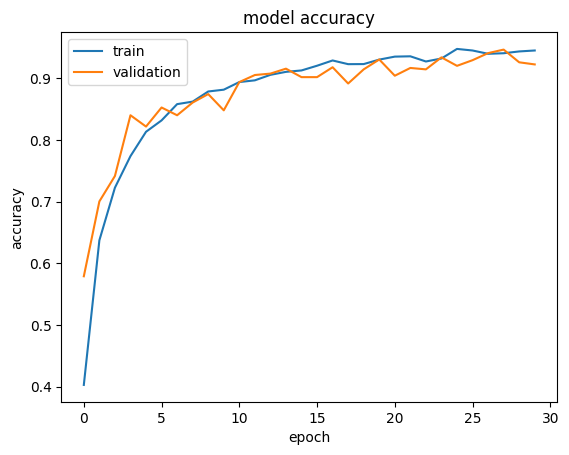

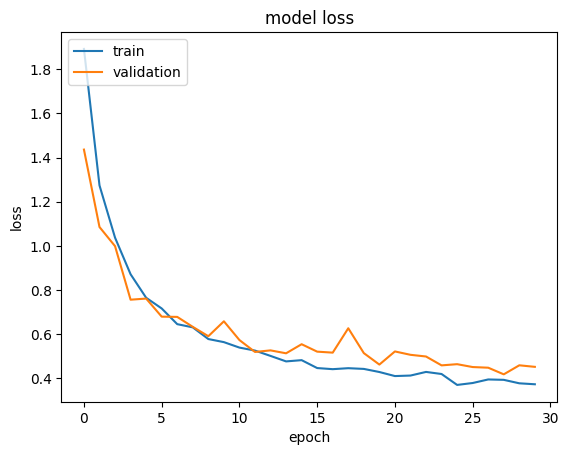

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

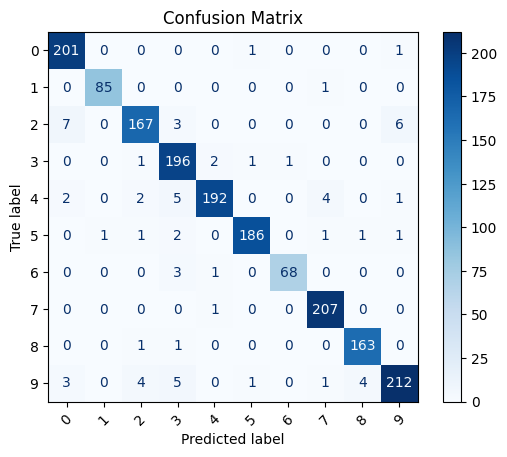


📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9437    0.9901    0.9663       203
           1     0.9884    0.9884    0.9884        86
           2     0.9489    0.9126    0.9304       183
           3     0.9116    0.9751    0.9423       201
           4     0.9796    0.9320    0.9552       206
           5     0.9841    0.9637    0.9738       193
           6     0.9855    0.9444    0.9645        72
           7     0.9673    0.9952    0.9810       208
           8     0.9702    0.9879    0.9790       165
           9     0.9593    0.9217    0.9401       230

    accuracy                         0.9599      1747
   macro avg     0.9639    0.9611    0.9621      1747
weighted avg     0.9605    0.9599    0.9598      1747


✅ Overall Test Accuracy: 0.9599

🎯 Per-Class Accuracy:
Class 0: 99.01%
Class 1: 98.84%
Class 2: 91.26%
Class 3: 97.51%
Class 4: 93.20%
Class 5: 96.37%
Class 6: 94.44%
Class 7: 99.52%
Class 8: 98.79%
Class 9: 92.17%

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score
)

# Step 1: Predict class probabilities
y_pred_probs = model.predict(X_test, verbose=0)

# Step 2: Convert predictions and true labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# For categorical_crossentropy (one-hot labels)
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)
else:  # For sparse_categorical_crossentropy (integer labels)
    y_true = y_test


# Step 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Step 5: Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Step 3: Overall Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Test Accuracy: {acc:.4f}")

# Step 6: Per-Class Accuracy
print("\n🎯 Per-Class Accuracy:")
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, a in enumerate(class_acc):
    print(f"Class {i}: {a:.2%}")


In [ ]:
# Testing LSTM Model

In [ ]:
def extract_features_rnn(file_path, n_mfcc=40):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

features = []
labels = []

for index, row in meta_data.iterrows():
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    label = row['class']
    mfccs = extract_features_rnn(file_path)
    if mfccs is not None:
        features.append(mfccs)
        labels.append(label)

features = np.array(features)
labels = np.array(labels)

X = np.array(features)
y = np.array(labels)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Build an RNN Model
rnn_model = Sequential([
    LSTM(128, input_shape=(features.shape[1], 1), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(one_hot_labels.shape[1], activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,778 (471.79 KB)

 Trainable params: 120,778 (471.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#Training the RNN model

history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2098 - loss: 2.1396 - val_accuracy: 0.3371 - val_loss: 1.7789
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3362 - loss: 1.8052 - val_accuracy: 0.4259 - val_loss: 1.5634
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4467 - loss: 1.5529 - val_accuracy: 0.5094 - val_loss: 1.3745
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5276 - loss: 1.3740 - val_accuracy: 0.5695 - val_loss: 1.2156
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5493 - loss: 1.2863 - val_accuracy: 0.5942 - val_loss: 1.1493
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6037 - loss: 1.1716 - val_accuracy: 0.6228 - val_loss: 1.1222
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6210 - loss: 1.1350 - val_accuracy: 0.6554 - val_loss: 1.0257
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6526 - loss: 1.0461 - val_accuracy

In [ ]:
test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

55/55 - 0s - 5ms/step - accuracy: 0.8180 - loss: 0.5719
Test Accuracy: 0.82


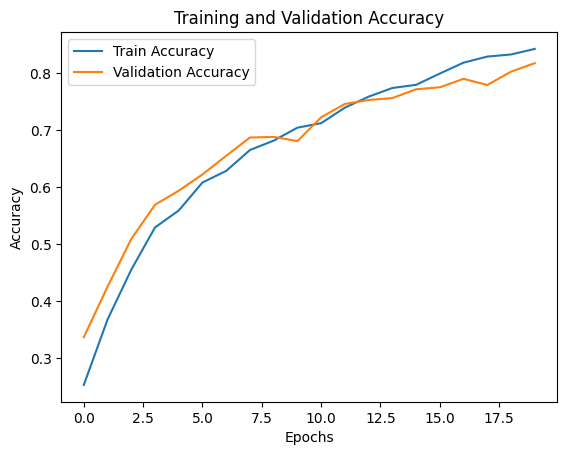

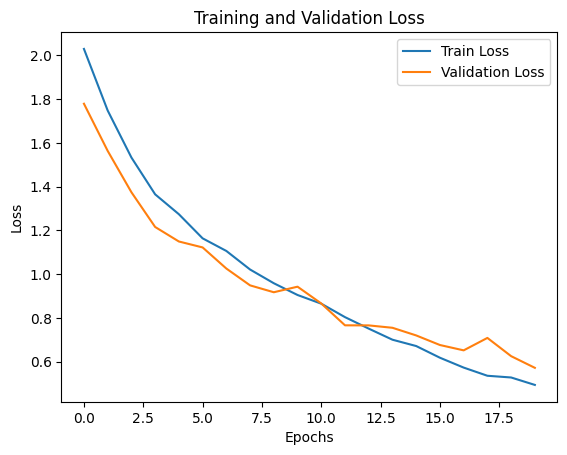

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()